In [1]:
import pandas as pd
import numpy as np
import plotly.express as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.feature_selection import SelectKBest,mutual_info_regression
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.metrics as m 
import missingno as mso

from joblib import dump

In [2]:
url="kc_house_data.csv"
df=pd.read_csv(url)
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [3]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [4]:
num_cols=["id","sqft_living","sqft_lot","lat","sqft_lot15"]
cat_cols=["date","bedrooms","bathrooms","floors","waterfront","view","condition","grade","sqft_above","sqft_basement","yr_built","yr_renovated","zipcode",
"long","sqft_living"]

In [5]:
len(num_cols),len(cat_cols)

(5, 15)

In [6]:
num_trans=Pipeline(steps=[ 
    ("scaler",StandardScaler())  
])

cat_trans=Pipeline(steps=[ 
    ("encoder",OneHotEncoder(drop="first",handle_unknown="ignore"))
])

processor=ColumnTransformer(transformers=[ 
    ("numerical",num_trans,num_cols),
    ("categorical",cat_trans,cat_cols)  
])

model=Pipeline(steps=[ 
    ("processed",processor),
    ("selector",SelectKBest(mutual_info_regression)),
    ("regressor",RandomForestRegressor())
])

In [7]:
model

Pipeline(steps=[('processed',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'sqft_living',
                                                   'sqft_lot', 'lat',
                                                   'sqft_lot15']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['date', 'bedrooms',
                                                   'bathrooms', 'floors',
                                                   'waterfront', 'view',
                                                   'condition', 'grade',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'yr_renovated', 'zipcode',
                                                   'long', 'sqft_living'])])),
                ('selector',
                 SelectKBest(score_func=<function mutual_info_regression at 0x000001E4F59E4160>)),
                ('regressor', RandomForestRegressor())])

In [8]:
x,y=df.drop("price",axis=1),df["price"]

In [9]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=1)

In [10]:
param_grid={
    "selector__k":[5,10,1],
    "regressor__criterion":["squared_error","absolute_error","friedman_mse","poisson"],
    "regressor__n_estimators":[10,50,10],
    "regressor__max_depth":[10,50,10]
}

In [11]:
# result=GridSearchCV(model,param_grid,n_jobs=-1,verbose=1)
# result.fit(xtrain,ytrain)

In [12]:
# result.best_params_

In [13]:
model.fit(xtrain,ytrain)

Pipeline(steps=[('processed',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'sqft_living',
                                                   'sqft_lot', 'lat',
                                                   'sqft_lot15']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['date', 'bedrooms',
                                                   'bathrooms', 'floors',
                                                   'waterfront', 'view',
                                                   'condition', 'grade',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'yr_renovated', 'zipcode',
                                                   'long', 'sqft_living'])])),
                ('selector',
                 SelectKBest(score_func=<function mutual_info_regression at 0x000001E4F59E4160>)),
                ('regressor', RandomForestRegressor())])

In [14]:
ypred=model.predict(xtest)

C:\Users\MY PC\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 7, 8, 9, 11, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [15]:
print("Metics")
print(f'MAE: {m.mean_absolute_error(ytest, ypred):.2f}')
print(f'MSE: {m.mean_squared_error(ytest, ypred):.2f}')
print(f'R2: {m.r2_score(ytest, ypred):.2f}')

Metics
MAE: 99266.86
MSE: 41013649328.18
R2: 0.76


In [16]:
print('Decision Tree Regressor')
print(f'Train Score: {model.score(xtrain, ytrain):.2f}')
print(f'Test Score: {model.score(xtest, ytest):.2f} ')

Decision Tree Regressor
Train Score: 0.97


C:\Users\MY PC\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 7, 8, 9, 11, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test Score: 0.76 


<Axes: ylabel='Density'>

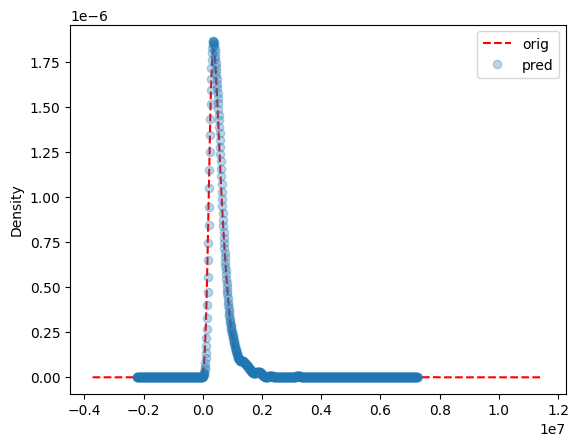

In [17]:
# ytest.values because it is not numpy array
evaldf=pd.DataFrame([ytest.values,ypred],index=["orig","pred"]).T
ax=evaldf.plot(kind="kde",y="orig",style="r--")
evaldf.plot(kind="kde",y="pred",linewidth=10,alpha=.3,style="o",ax=ax)

In [18]:
dump(model,"housedata.jb")

['housedata.jb']